In [1]:
import numpy as np
from numpy import matlib as mb
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy import linalg
from scipy.spatial import Delaunay

# Model Class

In [2]:
# Dynamics and model parameters
class Model:
    def __init__(self, N, t_f, Yset, Uset, Y_N, V_N, x_0):
        # control and state dimensions
        self.n_u = 2
        self.n_x = 4
        
        # gravity
        self.g = 9.81
        
        # IC
        self.x_0 = x_0
        
        # continuous time Jacobians \dot{x} = Ax + B(u + L)
        self.A_c = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0]])
        self.B_c = np.array([[1, 0], [0, 1], [0, 0], [0, 0]])
        self.l   = np.array([0, -self.g])
        
        # time parameters
        self.N = N
        self.t_f = t_f
        
        # constraints
        self.Yset = Yset
        self.Uset = Uset
        self.Y_N = Y_N
        self.V_N = V_N
        
    # Jacobian discretization
    def get_dt_jacs(self, dt):
        Xi = np.zeros((3*self.n_x + self.n_u, 3*self.n_x + self.n_u))
        Xi[0:self.n_x, 0:self.n_x] = self.A_c
        Xi[self.n_x:2*self.n_x, self.n_x:2*self.n_x] = -self.A_c.T
        Xi[2*self.n_x:3*self.n_x, 2*self.n_x:3*self.n_x] = self.A_c
        Xi[2*self.n_x:3*self.n_x, 3*self.n_x:3*self.n_x+self.n_u] = np.squeeze(self.B_c)
        Psi = linalg.expm(Xi * dt)
        
        A_k = Psi[0:self.n_x, 0:self.n_x]
        B_k = Psi[2*self.n_x:3*self.n_x, 3*self.n_x:3*self.n_x+self.n_u]
        
        return A_k, B_k

# Subproblem 1

In [3]:
# Solves for smallest feasible safety set
class SP1:
    def __init__(self, model):
        self.H = None
        self.e = None
        self.f = None
        self.x = None
        self.vertices = None
        self.simplices = None
        
        self.nset = len(model.Yset)
        self.model = model

        self.triangulate()
        self.facet_enumeration()

        self.generate_objective()

    # Generate objective function
    def generate_objective(self):
        d_min = []
        d_max = []
        for lv in range(self.nset - 1):
            d_min.append(self.get_min_dist(lv, lv+1))
            d_max.append(self.get_max_dist(lv, lv+1))

        f = [0]
        f.append(1)

        for lv in range(1, self.nset - 1):
            a_max = (f[lv] - f[lv-1]) / d_min[lv-1]
            f.append(np.squeeze(a_max * d_max[lv] + f[lv]))

        H = []
        e = []
        
        v0 = self.model.Yset[0][0]
        v1 = self.model.Yset[0][1]
        v2 = self.model.Yset[0][2]

        f0 = f[0]
        f1 = f[0]
        f2 = f[0]

        A = np.array([np.append(v0, 1),
                      np.append(v1, 1),
                      np.append(v2, 1)])
        b = np.array([[f0],
                      [f1],
                      [f2]])

        ab = np.squeeze(np.linalg.inv(A) @ b)
        H.append(ab[0:2])
        e.append(ab[2])

        for lv1 in range(self.nset - 1):
            for lv2 in range(len(self.simplices[lv1])):
                v0 = self.vertices[lv1][self.simplices[lv1][lv2, 0]]
                v1 = self.vertices[lv1][self.simplices[lv1][lv2, 1]]
                v2 = self.vertices[lv1][self.simplices[lv1][lv2, 2]]

                f0 = f[lv1] if v0.tolist() in self.model.Yset[lv1].tolist() else f[lv1 + 1]
                f1 = f[lv1] if v1.tolist() in self.model.Yset[lv1].tolist() else f[lv1 + 1]
                f2 = f[lv1] if v2.tolist() in self.model.Yset[lv1].tolist() else f[lv1 + 1]

                A = np.array([np.append(v0, 1),
                              np.append(v1, 1),
                              np.append(v2, 1)])
                b = np.array([[f0],
                              [f1],
                              [f2]])

                ab = np.squeeze(np.linalg.inv(A) @ b)
                H.append(ab[0:2])
                e.append(ab[2])


        self.H = np.array(H)
        self.e = np.array(e)
        self.f = f

    # Triangulate constraint sets
    def triangulate(self):
        # Use Delaunay triangulation to generate graph
        delaunay = []
        simplices = []
        vertices = []
        for lv in range(self.nset - 1):
            points = np.block([[self.model.Yset[lv]], [self.model.Yset[lv+1]]])
            delaunay.append(Delaunay(points))
            simplices.append(delaunay[lv].simplices)
            vertices.append(points)

        self.simplices = simplices
        self.vertices = vertices

        # Get rid of edges making up boundaries and inside set
        for lv in range(self.nset - 1):
            ind = 0
            while ind < len(self.simplices[lv]):
                v0 = vertices[lv][self.simplices[lv][ind, 0]]
                v1 = vertices[lv][self.simplices[lv][ind, 1]]
                v2 = vertices[lv][self.simplices[lv][ind, 2]]

                same_set = v0.tolist() in self.model.Yset[lv].tolist() \
                           and v1.tolist() in self.model.Yset[lv].tolist() \
                           and v2.tolist() in self.model.Yset[lv].tolist()
                same_set = same_set or v0.tolist() in self.model.Yset[lv+1].tolist() \
                           and v1.tolist() in self.model.Yset[lv+1].tolist() \
                           and v2.tolist() in self.model.Yset[lv+1].tolist()

                if same_set:
                    self.simplices[lv] = np.delete(self.simplices[lv], ind, 0)
                else:
                    ind += 1

    # Get halfspace representation from vertex representation
    def facet_enumeration(self):
        A = []
        b = []
        for lv1 in range(self.nset):
            v0 = np.mean(self.model.Yset[lv1], 0)
            U = self.model.Yset[lv1] - v0
            U = np.block([[U], [U[0]]])

            h = []
            y = []
            for lv2 in range(self.model.Yset[lv1].shape[0]):
                ui = U[lv2]
                uj = U[lv2+1]
                t = - ui @ (uj - ui).reshape(-1, 1) / np.linalg.norm(uj - ui)**2
                z = ui + t * (uj - ui)
                a = z / np.linalg.norm(z)
                c = (v0 + ui) @ a.reshape(-1, 1)
                h.append(a)
                y.append(c[0])

            A.append(np.array(h))
            b.append(np.array(y))

        self.A = A
        self.b = b
    
    # Computes minimum distance between the ind1^th and ind2^th set, where X[ind1] \subset X[ind2]
    def get_min_dist(self, ind1, ind2):
        dmin = None
        for lv1 in range(self.model.Yset[ind1].shape[0]):
            d = np.abs(self.b[ind2].reshape(-1, 1) - self.A[ind2] @ self.model.Yset[ind1][lv1].reshape(-1, 1)) \
                / np.linalg.norm(self.A[ind2], axis=1).reshape(-1, 1)

            if dmin is None or min(d) < dmin:
                dmin = min(d)

        return dmin

    # Computes maximum distance between the ind1^th and ind2^th set, where X[ind1] \subset X[ind2]
    def get_max_dist(self, ind1, ind2):
        dmax = None
        X1 = np.block([[self.model.Yset[ind1]], [self.model.Yset[ind1][0]]])
        X2 = np.block([[self.model.Yset[ind2]], [self.model.Yset[ind2][0]]])
        for lv1 in range(self.A[ind1].shape[0]):
            d = None
            for lv2 in range(self.model.Yset[ind2].shape[0]):
                if self.A[ind1][lv1] @ X2[lv2].reshape(-1, 1) > self.b[ind1][lv1]:
                    dv = np.linalg.norm(X1[lv1] - X2[lv2])
                    if d is None or dv < d:
                        d = dv

                    dv = np.linalg.norm(X1[lv1+1] - X2[lv2])
                    if d is None or dv < d:
                        d = dv

            if dmax is None or d > dmax:
                dmax = d

        return dmax

    def minimize(self, Uset, N, t_f):
        # dimension variables
        n_u = self.model.n_u
        n_x = self.model.n_x
        n_prob = N * n_u + N * n_x + 1  # N control inputs, N states, 1 epigraph variable
        # time step
        dt = t_f / N
        # discrete-time Jacobians
        A_k, B_k = self.model.get_dt_jacs(dt)
        A = np.broadcast_to(A_k, (N, n_x, n_x))
        B = np.broadcast_to(B_k, (N, n_x, n_u))
        # state
        u = cvx.Variable((n_u, N))
        x = cvx.Variable((n_x, N+1))
        t = cvx.Variable(1)
        
        # constraints
        constraints = []
        # control
        for lv in range(N):
            constraints += [u[:, lv] >= Uset[0]]
            constraints += [u[:, lv] <= Uset[1]]
        
        # dynamics
        constraints += [x[:, 0] == self.model.x_0]
        for lv in range(N):
            constraints += [x[:, lv+1] == A_k @ x[:, lv] + B_k @ (u[:, lv] +  np.array([0, -self.model.g]))]
        
        # piecewise constraints
        for lv in range(self.H.shape[0]):
            constraints += [self.H[lv, :] @ x[np.array([0,2]), -1] + self.e[lv] <= t]
            
        # landing constraints
        constraints += [x[1, -1] >= self.model.V_N[0]]
        constraints += [x[1, -1] <= self.model.V_N[1]]
        constraints += [x[3, -1] >= self.model.Y_N[0]]
        constraints += [x[3, -1] <= self.model.Y_N[1]]

        # solve
        prob = cvx.Problem(cvx.Minimize(t), constraints)
        prob.solve()
        print('cost = ', prob.value)
        self.x = x
        self.u = u
        eps = -1e-5
        print('f', np.array(subprob1.f))
        return np.argmax(np.array(subprob1.f) - prob.value > eps)
    
    def plot_objective(self):
        plt.rcParams['text.usetex'] = True
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": "3d"})

        # Plot safety sets
        for lv1 in range(1,len(self.model.Yset)):
            x = self.model.Yset[len(self.model.Yset) - lv1 - 1][:, 0]
            y = self.model.Yset[len(self.model.Yset) - lv1 - 1][:, 1]
            z = np.ones(x.shape)*lv1*0.01
            surf = ax1.plot_trisurf(x, y, z, edgecolor='none', antialiased=False)

        ax1.set_xlabel(r'$\dot{r}^x$', fontsize=20)
        ax1.set_ylabel(r'$r^x$', fontsize=20)
        ax1.set_zlim([0, 1])
        ax1.zaxis.line.set_lw(0.)
        ax1.set_zticks([])
        ax1.view_init(azim=270, elev=90)

        # Plot triangulation
        surf = ax2.plot_trisurf(self.model.Yset[0][:, 0], self.model.Yset[0][:, 1], 
                                np.zeros(len(self.model.Yset[0])),
                                edgecolor='none', antialiased=False, color='C0')
        for lv1 in range(len(self.simplices)-1):
            for lv2 in range(len(self.simplices[lv1])):
                x = np.array([self.vertices[lv1][self.simplices[lv1][lv2][0]][0],
                              self.vertices[lv1][self.simplices[lv1][lv2][1]][0],
                              self.vertices[lv1][self.simplices[lv1][lv2][2]][0]])
                y = np.array([self.vertices[lv1][self.simplices[lv1][lv2][0]][1],
                              self.vertices[lv1][self.simplices[lv1][lv2][1]][1],
                              self.vertices[lv1][self.simplices[lv1][lv2][2]][1]])
                z = np.zeros(3)
                max_set = lv1
                inXp = self.vertices[lv1][self.simplices[lv1][lv2][0]].tolist() \
                        in self.model.Yset[lv1+1].tolist() \
                       or self.vertices[lv1][self.simplices[lv1][lv2][1]].tolist() \
                        in self.model.Yset[lv1+1].tolist() \
                       or self.vertices[lv1][self.simplices[lv1][lv2][2]].tolist() \
                        in self.model.Yset[lv1+1].tolist()
                surf = ax2.plot_trisurf(x, y, z, edgecolor='black', antialiased=False)


        ax2.set_xlabel(r'$\dot{r}^{x}$')
        ax2.set_ylabel(r'$r^x$')
        ax2.zaxis.line.set_lw(0.)
        ax2.set_zticks([])
        ax2.view_init(azim=270, elev=90)

        # Plot objective
        for lv1 in range(len(self.simplices)-1):
            for lv2 in range(len(self.simplices[lv1])):
                x = np.array([self.vertices[lv1][self.simplices[lv1][lv2][0]][0],
                              self.vertices[lv1][self.simplices[lv1][lv2][1]][0],
                              self.vertices[lv1][self.simplices[lv1][lv2][2]][0]])
                y = np.array([self.vertices[lv1][self.simplices[lv1][lv2][0]][1],
                              self.vertices[lv1][self.simplices[lv1][lv2][1]][1],
                              self.vertices[lv1][self.simplices[lv1][lv2][2]][1]])
                z = np.array([self.f[lv1] if self.vertices[lv1][self.simplices[lv1][lv2][0]].tolist() \
                                  in self.model.Yset[lv1].tolist() else self.f[lv1 + 1],
                              self.f[lv1] if self.vertices[lv1][self.simplices[lv1][lv2][1]].tolist() \
                                  in self.model.Yset[lv1].tolist() else self.f[lv1 + 1],
                              self.f[lv1] if self.vertices[lv1][self.simplices[lv1][lv2][2]].tolist() \
                                  in self.model.Yset[lv1].tolist() else self.f[lv1 + 1]])
                surf = ax3.plot_trisurf(x, y, z, edgecolor='black',
                                       antialiased=False, color='cyan')

        ax3.set_xlabel(r'$\dot{r}^x$', fontsize=25)
        ax3.set_ylabel(r'$r^x$', fontsize=25)
        ax3.set_zlabel(r'$\hat{q}$', fontsize=25)

        plt.show()

        return

# Subproblem 2

In [4]:
# Solves for blamelessly optimal control
class SP2:
    def __init__(self, model, Yset, sig_q, sig_r):
        # Constraints
        self.x_min = min(Yset[:, 1])
        self.x_max = max(Yset[:, 1])
        self.v_min = min(Yset[:, 0])
        self.v_max = max(Yset[:, 0])
        
        self.u_min = model.Uset[0]
        self.u_max = model.Uset[1]
        # state
        self.x = []
        self.x.append(model.x_0)
        
        self.model = model
        
        # input cost matrix
        self.Q = sig_q**2 * np.eye(self.model.n_u)
        # regulator cost
        self.R = sig_r**2 * np.eye(2)
        
    def response(self, tk):
        dt = self.model.t_f / self.model.N
        N_r = int((self.model.t_f-tk) / dt)
        
        S_t, M_t, L_t, Q_t = self.state_trans_matrix(N_r, dt)
        S_c, Q_c, G_c, W, T = self.state_trans_matrix_c(S_t, M_t, L_t, Q_t, N_r)

        S_Nt = S_c[np.array([(N_r-1)*self.model.n_x, (N_r-1)*self.model.n_x + 2]), :]
        M_Nt = M_t[np.array([(N_r-1)*self.model.n_x, (N_r-1)*self.model.n_x + 2]), :]
        L_Nt = L_t[np.array([(N_r-1)*self.model.n_x, (N_r-1)*self.model.n_x + 2])]

        H_c = S_Nt.T @ self.R @ S_Nt + Q_c
        H_c = 1 / 2 * (H_c + H_c.T)
        
        c = np.array([self.v_max + self.v_min, 0, self.x_max + self.x_min, 0])/2
        
        # Compute control input
        q_c = S_Nt.T @ self.R @ (M_Nt @ (np.column_stack([self.x[-1]] - c)) + L_Nt.reshape(-1, 1))
        u = cvx.Variable(N_r * self.model.n_u)
        objective = cvx.Minimize((1/2)*cvx.quad_form(u, H_c) + q_c.T @ u)
        constraints = [G_c @ u <= np.squeeze(W.T) + T @ self.x[-1]]
        prob = cvx.Problem(objective, constraints)
        result = prob.solve()
            
        mu_col = u.value
        mu_c = np.reshape(mu_col, (int(H_c.shape[0] / self.model.n_u), self.model.n_u))
        
        # Propagate model with current control
        A_k, B_k = self.model.get_dt_jacs(dt)
        
        # Get control at current time
        u_k = mu_c[0] + np.array([0, -self.model.g])
        self.x.append(A_k @ self.x[-1] + B_k @ u_k)
        
        if N_r == 2:
            self.x.append(A_k @ self.x[-1] + B_k @ (mu_c[1] + np.array([0, -self.model.g])))
        
        
    def state_trans_matrix(self, N, dt):
        S = np.zeros((self.model.n_x * N, self.model.n_u * N))
        M = np.zeros((self.model.n_x * N, self.model.n_x))
        
        A_k, B_k = self.model.get_dt_jacs(dt)
        A_prod = np.eye(self.model.n_x)
        for lv1 in range(N):
            M[self.model.n_x * lv1: self.model.n_x * (lv1 + 1), 
              0:self.model.n_x] = np.linalg.matrix_power(A_k, lv1 + 1)
            for lv2 in range(lv1 + 1):
                S[self.model.n_x * lv1:self.model.n_x * (lv1 + 1), 
                  self.model.n_u * lv2:self.model.n_u * (lv2 + 1)] = np.linalg.matrix_power(A_k, 
                                                                                            lv1 - lv2) @ B_k
            A_prod = A_k @ A_prod
            
        L = S @ np.tile(np.array([0, -self.model.g]), N)
    
        Q = np.kron(np.eye(N, dtype=int), self.Q)

        return S, M, L, Q
    
    def state_trans_matrix_c(self, S_t, M_t, L_t, Q_t, N):
        Q_c = linalg.block_diag(Q_t)
        G_2 = np.eye(self.model.n_u * N)

        S_c = S_t
        
        S_Nt = S_t[(N-1)*self.model.n_x:(N-1)*self.model.n_x + self.model.n_x, :]
        M_Nt = M_t[(N-1)*self.model.n_x:(N-1)*self.model.n_x + self.model.n_x, :]
        L_Nt = L_t[(N-1)*self.model.n_x:(N-1)*self.model.n_x + self.model.n_x]
        
        G_c = np.block([[S_Nt],
                        [-S_Nt],
                        [G_2],
                        [-G_2]])
        
        T = np.block([[-M_Nt],
                      [M_Nt],
                      [np.zeros((self.model.n_u * N, self.model.n_x))],
                      [np.zeros((self.model.n_u * N, self.model.n_x))]])
        
        W = np.block([self.v_max         - L_Nt[0],  # vel_x_max
                      self.model.V_N[1]  - L_Nt[1],  # vel_y_max
                      self.x_max         - L_Nt[2],  # r_x_max
                      self.model.Y_N[1]  - L_Nt[3],  # r_y_max
                      -self.v_min        + L_Nt[0],  # vel_x_min
                      -self.model.V_N[0] + L_Nt[1],  # vel_y_min
                      -self.x_min        + L_Nt[2],  # r_x_min
                      -self.model.Y_N[0] + L_Nt[3],  # r_y_min
                      mb.repmat(self.u_max, 1, N),
                      mb.repmat(-self.u_min, 1, N)])

        return S_c, Q_c, G_c, W, T
        

# No safety constraints

In [5]:
# Solves for optimal control
class SP_nosafety:
    def __init__(self, model, c, sig_q, sig_r):
        # Constraints
        self.u_min = model.Uset[0]
        self.u_max = model.Uset[1]
        # state
        self.x = []
        self.x.append(model.x_0)
        
        self.c = c
        
        self.model = model
        
        # input cost matrix
        self.Q = sig_q**2 * np.eye(self.model.n_u)
        # terminal cost matrix
        self.R = sig_r**2 * np.eye(2)
        
    def response(self, tk):
        dt = self.model.t_f / self.model.N
        N_r = int((self.model.t_f-tk) / dt)
        
        S_t, M_t, L_t, Q_t = self.state_trans_matrix(N_r, dt)
        S_c, Q_c, G_c, W, T = self.state_trans_matrix_c(S_t, M_t, L_t, Q_t, N_r)
        
        S_Nt = S_c[np.array([(N_r-1)*self.model.n_x, (N_r-1)*self.model.n_x + 2]), :]
        M_Nt = M_t[np.array([(N_r-1)*self.model.n_x, (N_r-1)*self.model.n_x + 2]), :]
        L_Nt = L_t[np.array([(N_r-1)*self.model.n_x, (N_r-1)*self.model.n_x + 2])]

        H_c = S_Nt.T @ self.R @ S_Nt + Q_c
        H_c = 1 / 2 * (H_c + H_c.T)
        
        # Compute control input
        q_c = S_Nt.T @ self.R @ (M_Nt @ (np.column_stack([self.x[-1]] - self.c)) + L_Nt.reshape(-1, 1))
        u = cvx.Variable(N_r * self.model.n_u)
        objective = cvx.Minimize((1/2)*cvx.quad_form(u, H_c) + q_c.T @ u)
        constraints = [G_c @ u <= np.squeeze(W.T) + T @ self.x[-1]]
        prob = cvx.Problem(objective, constraints)
        result = prob.solve()
            
        mu_col = u.value
        mu_c = np.reshape(mu_col, (int(H_c.shape[0] / self.model.n_u), self.model.n_u))
        
        # Propagate model with current control
        A_k, B_k = self.model.get_dt_jacs(dt)
        
        # Get control at current time
        u_k = mu_c[0] + np.array([0, -self.model.g])
        self.x.append(A_k @ self.x[-1] + B_k @ u_k)
        
        if N_r == 2:
            self.x.append(A_k @ self.x[-1] + B_k @ (mu_c[1] + np.array([0, -self.model.g])))
        
        
    def state_trans_matrix(self, N, dt):
        S = np.zeros((self.model.n_x * N, self.model.n_u * N))
        M = np.zeros((self.model.n_x * N, self.model.n_x))
        
        A_k, B_k = self.model.get_dt_jacs(dt)
        A_prod = np.eye(self.model.n_x)
        for lv1 in range(N):
            M[self.model.n_x * lv1: self.model.n_x * (lv1 + 1), 
              0:self.model.n_x] = np.linalg.matrix_power(A_k, lv1 + 1)
            for lv2 in range(lv1 + 1):
                S[self.model.n_x * lv1:self.model.n_x * (lv1 + 1), 
                  self.model.n_u * lv2:self.model.n_u * (lv2 + 1)] = np.linalg.matrix_power(A_k, 
                                                                                            lv1 - lv2) @ B_k
            A_prod = A_k @ A_prod
            
        L = S @ np.tile(np.array([0, -self.model.g]), N)
    
        Q = np.kron(np.eye(N, dtype=int), self.Q)

        return S, M, L, Q
    
    def state_trans_matrix_c(self, S_t, M_t, L_t, Q_t, N):
        Q_c = linalg.block_diag(Q_t)
        G_2 = np.eye(self.model.n_u * N)

        S_c = S_t
        
        S_Nt = np.block([[S_t[(N-1)*self.model.n_x + 1, :]],
                         [S_t[(N-1)*self.model.n_x + 3, :]]])
        M_Nt = np.block([[M_t[(N-1)*self.model.n_x + 1, :]],
                         [M_t[(N-1)*self.model.n_x + 3, :]]])
        L_Nt = L_t[(N-1)*self.model.n_x:(N-1)*self.model.n_x + self.model.n_x]
        
        G_c = np.block([[S_Nt],
                        [-S_Nt],
                        [G_2],
                        [-G_2]])
        
        T = np.block([[-M_Nt],
                      [M_Nt],
                      [np.zeros((self.model.n_u * N, self.model.n_x))],
                      [np.zeros((self.model.n_u * N, self.model.n_x))]])
        
        W = np.block([self.model.V_N[1]  - L_Nt[1],  # vel_y_max
                      self.model.Y_N[1]  - L_Nt[3],  # r_y_max
                      -self.model.V_N[0] + L_Nt[1],  # vel_y_min
                      -self.model.Y_N[0] + L_Nt[3],  # r_y_min
                      mb.repmat(self.u_max,  1, N),
                      mb.repmat(-self.u_min, 1, N)])

        return S_c, Q_c, G_c, W, T

# Constants

In [6]:
# Time parameters
N = 20
t_f = 12

# Initial condition
x_0 = np.array([-10, -5, -350, 100])  # [v_x, v_y, r_x, r_y]

# Safety sets
Yset = [np.array([[-0.5, -5], 
                  [ 0.5, -5],
                  [ 0.5,  5],
                  [-0.5,  5]]),
        np.array([[-4, -15],
                  [ 4, -15],
                  [ 4,  12],
                  [-4,  12]]),
        np.array([[-7, -30],
                  [ 7, -30],
                  [ 7,  26],
                  [-7,  26]]),
        np.array([[-10, -40],
                  [ 10, -40],
                  [ 10,  35],
                  [-10,  35]]),
        np.array([[-15, -45],
                  [ 15, -45],
                  [ 15,  52],
                  [-15,  52]]) ]

# Control sets
Uset = np.array([[-10, 9], [10, 30]])

# Terminal state
Y_N = np.array([[-0.1], [0.1]])
V_N = np.array([[-0.5], [0.5]])

sig_q = 5e0
sig_r = np.diag(np.array([5e-1, 1e-0]))

In [7]:
model = Model(N, t_f, Yset, Uset, Y_N, V_N, x_0)

# Create object 
subprob1 = SP1(model)
min_set = subprob1.minimize(Uset, N, t_f)
print('Solution in set Y'+str(min_set))

cost =  3.3655988693814582
f [  0.           1.           5.37058815  20.58068147 110.42186157]
Solution in set Y2


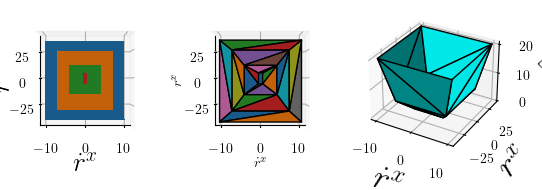

In [8]:
subprob1.plot_objective()

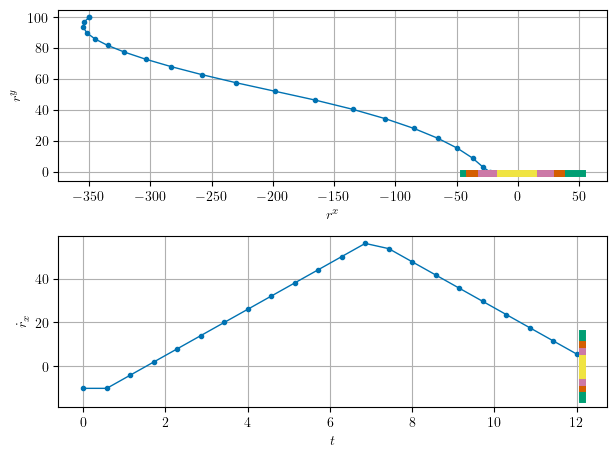

In [9]:
blameless_sol = np.block([[x_0], [subprob1.x.value.T]])

with plt.style.context(("seaborn-colorblind",)):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.tight_layout(pad=2.0)

    ax1.plot(blameless_sol[:, 2], blameless_sol[:, 3], '.-', linewidth=1)
    for lv in range(len(Yset)-1):
        ax1.plot(Yset[len(Yset)- lv-1][1:3, 1], -(x_0[3] * 0.01)*np.ones(2), linewidth=5)
    ax1.grid(True)
    ax1.set_xlabel(r'$r^x$')
    ax1.set_ylabel(r'$r^y$')

    t = np.linspace(0, t_f, N+2)

    ax2.plot(t, blameless_sol[:, 0], '.-', linewidth=1)
    for lv in range(len(Yset)-1):
        ax2.plot((t[-1] * 1.01)*np.ones(2), Yset[len(Yset)- lv-1][0:2, 0], linewidth=5,
                 label=r'$\mathcal{Y}$'+str(lv+1))
    ax2.grid(True)
    ax2.set_xlabel(r'$t$')
    ax2.set_ylabel(r'$\dot{r}_x$')

    plt.show()

In [10]:
subprob2 = SP2(model, Yset[min_set], sig_q, sig_r)

dt = model.t_f / model.N
t_k = 0
while abs(t_k - model.t_f) > 2*dt:
    subprob2.response(t_k)
    t_k += dt

In [11]:
# Brute force
infeas = 1
ind = 0
while infeas:
    subprob_brute = SP2(model, Yset[ind], sig_q, sig_r)

    dt = model.t_f / model.N
    t_k = 0
    try:
        while abs(t_k - model.t_f) > 2*dt:
            subprob_brute.response(t_k)
            t_k += dt
    except:
        ind += 1
        
    if len(subprob_brute.x) > 1:
        infeas = 0

In [12]:
c = np.array([Yset[0][0, 0] + Yset[0][1, 0], 0, Yset[0][0, 1] + Yset[0][1, 1], 0]) / 2

subprob_nosafety_1 = SP_nosafety(model, c, sig_q, sig_r)

dt = model.t_f / model.N
t_k = 0
while abs(t_k - model.t_f) > 2*dt:
    subprob_nosafety_1.response(t_k)
    t_k += dt
    
subprob_nosafety_2 = SP_nosafety(model, c, 0.03*sig_q, sig_r)

dt = model.t_f / model.N
t_k = 0
while abs(t_k - model.t_f) > 2*dt:
    subprob_nosafety_2.response(t_k)
    t_k += dt

In [ ]:
line_width = 2
plt.rcParams['text.usetex'] = True

traj = [np.array(subprob_brute.x), 
        np.array(subprob2.x), 
        np.array(subprob_nosafety_1.x), 
        np.array(subprob_nosafety_2.x)]

with plt.style.context(("seaborn-colorblind",)):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.tight_layout(pad=2.0)

    # Trajectory plot
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(True)
    ax1.set_xlabel(r"$r^x$", fontsize=25)
    ax1.set_ylabel(r"$r^y$", fontsize=25)

    # Trajectories
    ax1.plot(traj[0][:, 2], traj[0][:, 3], '.-', linewidth=line_width, 
            label=r'$\textrm{Brute force}$')
    ax1.plot(traj[1][:, 2], traj[1][:, 3], 'x:', linewidth=line_width, 
            label=r'$\textrm{Blamelessly Optimal Control}$')
    ax1.plot(traj[2][:, 2], traj[2][:, 3], '+:', linewidth=line_width, 
            label=r'$\textrm{Optimal, } Q = 5^2 I$')
    ax1.plot(traj[3][:, 2], traj[3][:, 3], '.-', linewidth=line_width, 
            label=r'$\textrm{Optimal, } Q = 0.15^2 I$')
    
    ax1.legend(fontsize=14, loc='upper right')
    
    # Nested contraint sets
    for lv in range(len(Yset)-1):
        ax1.plot(Yset[len(Yset) - lv-2][1:3, 1], -(x_0[3] * 0.01)*np.ones(2), linewidth=5)

    # Velocity plot
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(True)
    ax2.set_xlabel(r"$t$", fontsize=25)
    ax2.set_ylabel(r"$\dot{r}^x$", fontsize=25)

    t = np.linspace(0, t_f, len(subprob_brute.x))

    # Velocity
    ax2.plot(t, traj[0][:, 0], '.-', linewidth=line_width)
    ax2.plot(t, traj[1][:, 0], 'x:', linewidth=line_width)
    ax2.plot(t, traj[2][:, 0], '+:', linewidth=line_width)
    ax2.plot(t, traj[3][:, 0], '.-', linewidth=line_width)
    
    # Nested constraint sets
    for lv in range(len(Yset)-1):
        ax2.plot((t[-1] * 1.01)*np.ones(2), Yset[len(Yset) - lv-2][0:2, 0], linewidth=5, 
                 label=r'$\mathcal{Y}$'+str(len(Yset) - lv-1))

    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles[::-1], labels[::-1], fontsize=14, loc='lower center', ncol=len(Yset)-1)

    plt.show()